In [109]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import os
import pandas as pd
import numpy as np

import mne
from mne.minimum_norm import apply_inverse, make_inverse_operator
from mne.decoding import GeneralizingEstimator

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.decomposition import PCA

from scipy.stats import spearmanr

import multiprocess as mp
import dill
# Required for multiprocess to work in Jupyter notebook
dill.settings['recurse'] = True

from functools import partial

In [106]:
# Useful constants for the rest of the code
sub_files = os.listdir("./sub_data")
n_subs = len(sub_files)

_, initial_sub_data = get_data(sub_files[0])
tpoints = initial_sub_data.shape[-1]

# Recordings were -200ms to 600ms, relative to the tone being played, collected at 161 points
t = np.linspace(-200, 600, tpoints)

# Helper function to get first index where condition is true
def index_of(cond):
    indices = np.where(cond)[0]
    
    if len(indices) == 0:
        return -1
    else:
        return indices[0]

# Helper for finding index of a particular point in time
def at_t(t_point):
    return index_of(t == t_point)

Reading C:\Users\isaac\Code\surp\sub_data\A0216_shepard-epo-lp20.fif ...


C:\Users\isaac\AppData\Local\Temp\ipykernel_19840\512867986.py:2: RuntimeWarning: This filename (./sub_data/A0216_shepard-epo-lp20.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  fif = mne.read_epochs(f"./sub_data/{filename}")


    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Adding metadata with 17 columns
7645 matching events found
No baseline correction applied
0 projection items activated


In [2]:
def get_perf_timecourse(X, y, decoder, perf_metric, n_splits=5):
    classifying = len(np.unique(y)) <= 2

    n_times = X.shape[-1]

    scores = np.zeros(n_times)
    pvalues = np.zeros(n_times)

    kf = KFold(n_splits, shuffle=True)
    split = lambda X, y: kf.split(X)

    if classifying:
        kf = StratifiedKFold(n_splits, shuffle=True)
        # Account for the fact that StratifiedKFold takes 2 arguments to split
        split = lambda X, y: kf.split(X, y)

    max_acc = 0

    for t in range(n_times):
        t_scores = []
        t_pvalues = []

        for train_indices, test_indices in split(X, y):
            decoder = decoder.fit(X[train_indices, :, t], y[train_indices])
            y_pred = decoder.predict(X[test_indices, :, t])

            if len(np.unique(y_pred)) > 1:
                score = perf_metric(y_pred, y[test_indices])
                acc = decoder.score(X[train_indices, :, t], y[train_indices])

                # if acc > max_acc:
                #     max_acc = acc
                #     print(acc)

                if classifying:
                    t_scores.append(score)
                    t_pvalues.append(0)
                else:
                    t_scores.append(score.statistic)
                    t_pvalues.append(score.pvalue)

        scores[t] = sum(t_scores) / len(t_scores)
        pvalues[t] = max(t_pvalues)

    return scores, pvalues


In [3]:
def get_data(filename):
    fif = mne.read_epochs(f"./sub_data/{filename}")
    
    metadata = fif.metadata
    stim_features = metadata[["freq", "condition", "trial_type"]].to_numpy()

    sub_data = fif.get_data(picks=["meg"])
    
    del fif

    return stim_features, sub_data

In [38]:
filters = {
    "pure": lambda features: (features[:,1] == "pure"),
    "complex": lambda features: (features[:,1] == "partial"),
    "ambiguous": lambda features: (features[:,1] == "shepard")
}

def get_sub_scores(filename):    
    stim_features, sub_data = get_data(filename)
    
    ridge_decoder = make_pipeline(
        StandardScaler(),
        Ridge()
    )
    
    freqs = stim_features[:, 0]

    sub_scores = { }
    
    for condition in filters:
        condition_filter = filters[condition](stim_features)

        print(f"Finding {condition} scores for {filename}...", end="\r")
        condition_scores, _ = get_perf_timecourse(sub_data[condition_filter], freqs[condition_filter], ridge_decoder, spearmanr)
        
        sub_scores[condition] = condition_scores
    
    del freqs, sub_data, stim_features

    return sub_scores
    
def get_gen_scores(filename):
    stim_features, sub_data = get_data(filename)
    freqs = stim_features[:, 0]

    ridge_decoder = make_pipeline(
        StandardScaler(),
        Ridge()
    )

    for condition in filters:
        condition_filter = filters[condition](stim_features)

        print(f"Finding generalized {condition} scores for {filename}...", end="\r")
        spearman_scorer = make_scorer(spearmanr, greater_is_better=True)

        time_gen = GeneralizingEstimator(ridge_decoder, scoring=spearman_scorer, n_jobs=-1)
        time_gen.fit(X=sub_data[condition_filter], y=freqs[condition_filter])
        output = time_gen.score(X=sub_data[condition_filter], y=freqs[condition_filter])
        
        first_elem = lambda tup: tup[0]
        first_elem_vectorized = np.vectorize(first_elem)
        sub_scores_gen = first_elem_vectorized(output)
        
MERGED_SCORES_LOCATION = "merged_scores.npy"

def save_merged_scores(merged_scores):
    np.save(MERGED_SCORES_LOCATION, merged_scores)

def load_merged_scores():
    empty = not os.path.isfile(MERGED_SCORES_LOCATION)
    merged_sub_scores = {
        "pure": np.zeros((n_subs, tpoints)),
        "complex": np.zeros((n_subs, tpoints)),
        "ambiguous": np.zeros((n_subs, tpoints)),
    }
    
    if not empty:
        try:
            merged_sub_scores = np.load("merged_scores.npy", allow_pickle=True)
        except Exception:
            empty = True
            return merged_sub_scores, empty
    
    return merged_sub_scores, empty

In [42]:
merged_sub_scores, empty = load_merged_scores()

# If merged scores have not already been saved, generate them (this takes a long time)
if empty:
    output = None

    try:
        pool = mp.Pool(8)
        output = pool.map(partial(get_sub_scores), sub_files)
    except KeyboardInterrupt as e:
        pass
    finally:
        pool.terminate()
        pool.join()

    merged_sub_scores = {
        "pure": np.zeros((n_subs, tpoints)),
        "complex": np.zeros((n_subs, tpoints)),
        "ambiguous": np.zeros((n_subs, tpoints)),
    }

    for i in range(n_subs):
        for condition in filters:
            merged_sub_scores[condition][i] = output[i][condition]

    save_merged_scores(merged_sub_scores)

Reading C:\Users\isaac\Code\surp\sub_data\A0216_shepard-epo-lp20.fif ...


C:\Users\isaac\AppData\Local\Temp\ipykernel_19840\512867986.py:2: RuntimeWarning: This filename (./sub_data/A0216_shepard-epo-lp20.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  fif = mne.read_epochs(f"./sub_data/{filename}")


    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Adding metadata with 17 columns
7645 matching events found
No baseline correction applied
0 projection items activated


## Heterogeneity Analysis

Ideas
* Butterfly plot
* Distributions of particular metrics
    * Score at particular time points - e.g. around the first peak (~75ms) and second (~500ms)
    * Scores around those time points
        * Mean
        * Max
    * Joint distribution of scores at the first and second peaks
    * Times at which max values occured
* Clustering analysis
    * t-SNE
    * Spectral
    * k-means
* Dimensionality reduction
    * LFA
    * umap
    * PCA

In [151]:
# Condition to be used for further analysis
CONDITION = "pure"
scores = merged_sub_scores[CONDITION]

Text(0, 0.5, 'Spearman correlation')

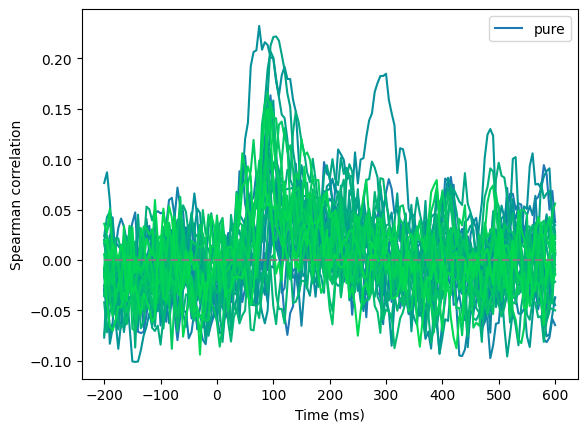

In [152]:
plotting_params = {
    "pure": {"color": "tab:blue", "alpha": 1},
    "complex": {"color": "tab:orange", "alpha": 0.7}, 
    "ambiguous": {"color": "tab:green", "alpha": 0.7}
}

rgb_colors = {
    "tab:blue": np.array([31/255, 119/255, 180/255]),
    "tab:orange": np.array([255/255, 127/255, 14/255]),
    "tab:green": np.array([44/255, 160/255, 44/255])
}

for i in range(n_subs):
    sub_params = plotting_params[CONDITION].copy()
    modifier = i/n_subs
    # Shift base color so different lines are distinguishable
    shifted_color = rgb_colors[sub_params["color"]] + modifier * np.array([-0.4,0.4,-0.4])
    sub_params["color"] = np.clip(shifted_color, 0, 1)

    plt.plot(t, scores[i], **sub_params)

plt.plot([], [], label=CONDITION, **plotting_params[CONDITION])

plt.plot(t, np.zeros_like(t), linestyle="--", color="gray")
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Spearman correlation")

<Axes: ylabel='Count'>

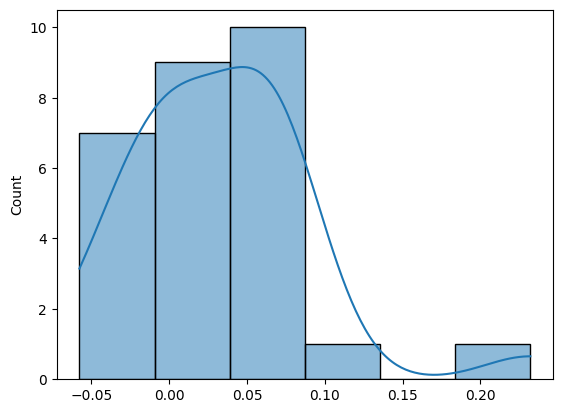

In [153]:
scores_at_t = scores[:, at_t(75)]
sns.histplot(scores_at_t, kde=True)

<Axes: ylabel='Count'>

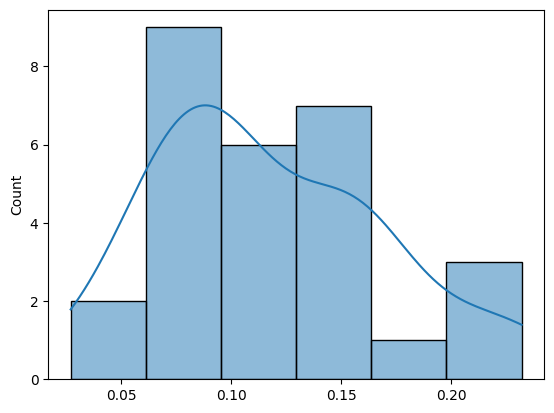

In [157]:
max_scores = scores[:,at_t(50):at_t(150)].max(axis=-1)
sns.histplot(max_scores, kde=True)

<Axes: ylabel='Count'>

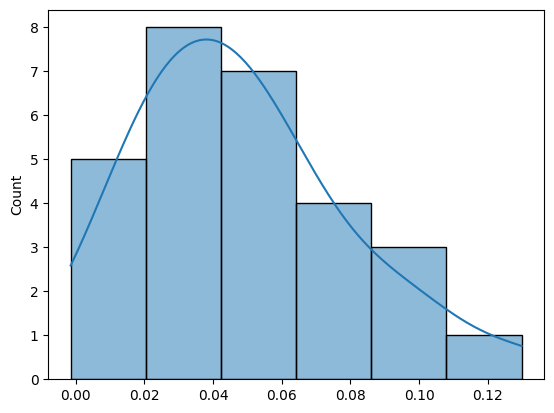

In [156]:
max_scores = scores[:,at_t(450):at_t(550)].max(axis=-1)
sns.histplot(max_scores, kde=True)

In [180]:
# Between-subject z-scores
btw_mean = scores.mean()
btw_std = scores.std()

btw_sub_z = (scores - btw_mean) / btw_std

# Within-subject z-scores
wtn_mean = scores.mean(axis=-1)
wtn_std = scores.std(axis=-1)

wtn_sub_z = ((scores.T - wtn_mean) / wtn_std).T

<Axes: ylabel='Count'>

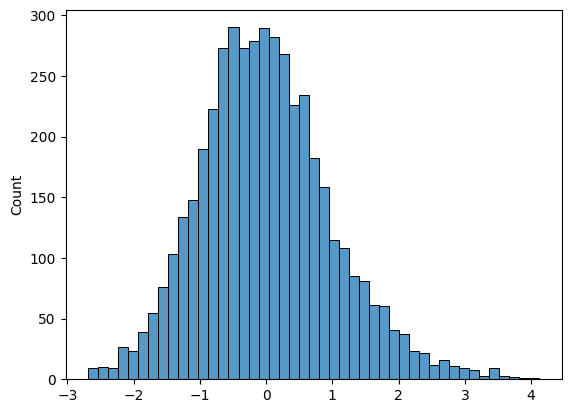

In [184]:
sns.histplot(wtn_sub_z.flatten())

scores.T

# Temporal Generalization

In [ ]:
decoder = make_pipeline(
    StandardScaler(),
    Ridge()
)

spearman_scorer = make_scorer(spearmanr, greater_is_better=True)
time_gen = GeneralizingEstimator(decoder, scoring=spearman_scorer, n_jobs=None)
time_gen.fit(X=sub_data[pure], y=freqs[pure])
output = time_gen.score(X=sub_data[pure], y=freqs[pure])

first_elem = lambda tup: tup[0]
first_elem_vectorized = np.vectorize(first_elem)
scores = first_elem_vectorized(output)

100%|██████████████████████████████████████████████| Fitting GeneralizingEstimator : 161/161 [00:04<00:00,   32.70it/s]
 55%|███████████████████████▏                  | Scoring GeneralizingEstimator : 14317/25921 [11:09<08:56,   21.61it/s]

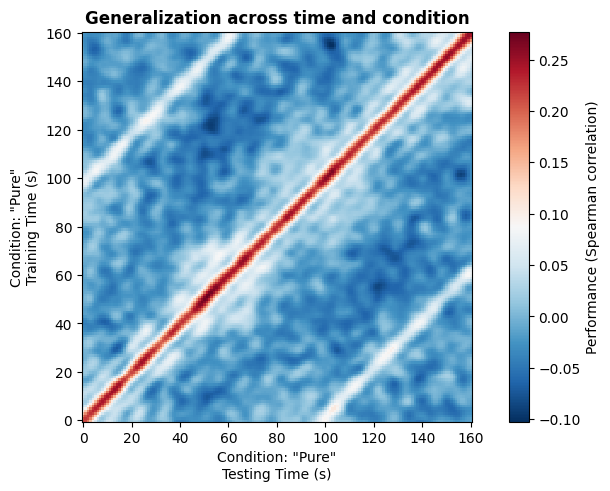

In [15]:
fig, ax = plt.subplots(layout="constrained")
im = ax.matshow(
    avg_scores_gen["ambiguous"],
    cmap="RdBu_r",
    origin="lower"
)
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    'Condition: "Pure"\nTesting Time (s)',
)
ax.set_ylabel('Condition: "Pure"\nTraining Time (s)')
ax.set_title("Generalization across time and condition", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (Spearman correlation)")
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

logistic_decoder = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

features_pc = stim_features[pure | complx,1] == "pure"
input_pc = sub_data[pure | complx]
score_pc, _ = get_perf_timecourse(input_pc, features_pc, logistic_decoder, roc_auc_score)

features_pa = stim_features[pure | ambiguous,1] == "pure"
input_pa = sub_data[pure | ambiguous]
score_pa, _ = get_perf_timecourse(input_pa, features_pa, logistic_decoder, roc_auc_score)

features_ca = stim_features[complx | ambiguous,1] == "partial"
input_ca = sub_data[complx | ambiguous]
score_ca, _ = get_perf_timecourse(input_ca, features_ca, logistic_decoder, roc_auc_score)

In [ ]:
plt.plot(t, score_pc, label="Pure vs. Complex")
plt.plot(t, score_pa, label="Pure vs. Ambiguous")
plt.plot(t, score_ca, label="Complex vs. Ambiguous")
plt.plot(t, 0.5 * np.ones_like(t), linestyle="--", color="gray")
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("ROC AUC Score")
plt.ylim([0,1])

In [ ]:
t0 = 40

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

kf = StratifiedKFold(5, shuffle=True)
X = input_pc[:,:,t0]
y = features_pc

for train, test in kf.split(X, y):
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)x
    s = roc_auc_score(y_pred, y_test)
    print("AUC:", s)

Text(0.5, 1.0, 't=35.0ms')

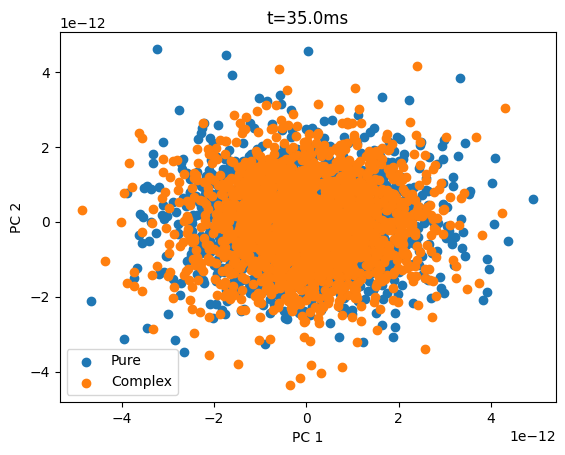

In [40]:
t0 = 47

pca = PCA(n_components=2, svd_solver="full")
transformed = pca.fit_transform(input_pc[:,:,t0])

transformed_pure = transformed[features_pc]
transformed_complx = transformed[~features_pc]

plt.scatter(transformed_pure[:,0], transformed_pure[:,1], label="Pure")
plt.scatter(transformed_complx[:,0], transformed_complx[:,1], label="Complex")
plt.legend()
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title(f"t={t[t0]}ms")

In [18]:
c = 0
loadings = pca.components_[c].copy()
n_top = 3
top_loadings = []

for i in range(n_top):
    max_idx = np.argmax(loadings)
    top_loadings.append((max_idx, loadings[max_idx]))
    loadings[max_idx] = 0
    
top_loadings

[(137, 0.20615029457880427),
 (121, 0.1937262323574115),
 (136, 0.16945149240978483)]

In [38]:
time_gen = GeneralizingEstimator(logistic_decoder, scoring="roc_auc", n_jobs=None)
time_gen.fit(X=input_pc, y=features_pc)
scores_gen_pc = time_gen.score(X=input_pc, y=features_pc)

100%|██████████████████████████████████████████████| Fitting GeneralizingEstimator : 161/161 [00:36<00:00,    4.40it/s]
100%|██████████████████████████████████████████| Scoring GeneralizingEstimator : 25921/25921 [14:39<00:00,   29.47it/s]


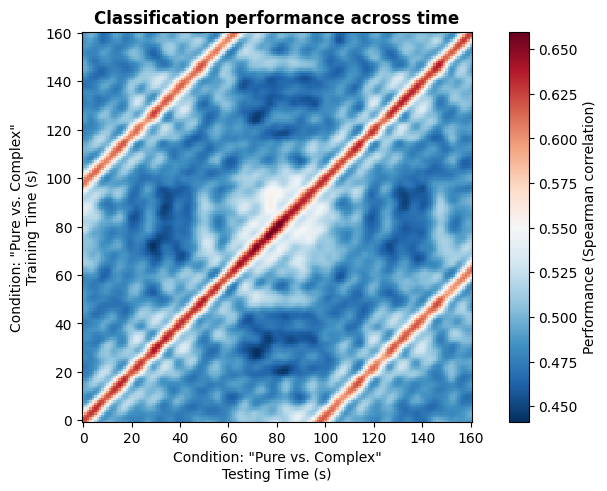

In [39]:
fig, ax = plt.subplots(layout="constrained")
im = ax.matshow(
    scores_gen_pc,
    cmap="RdBu_r",
    origin="lower"
)
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    'Condition: "Pure vs. Complex"\nTesting Time (s)',
)
ax.set_ylabel('Condition: "Pure vs. Complex"\nTraining Time (s)')
ax.set_title("Classification performance across time", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (Spearman correlation)")
plt.show()